In [1]:
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell as LSTM
from tensorflow.contrib.rnn import LSTMStateTuple as LSTMState
import numpy as np

In [2]:
HISTORY_TIMES = [3, 7, 15, 31, 47, 63, 95, 127]

PIECES = 256

ADDITIONAL_INPUT_SIZE = 6

In [3]:
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.01
batch_size = 64
voices = 7
epsilon = 1e-06

# Network Parameters
num_input = 88 * len(HISTORY_TIMES) + 88 + ADDITIONAL_INPUT_SIZE      # dimension of one input at moment
num_hidden_in_capsule = 100     # num of lstms in EACH CAPSULE!
num_ruler = 100    # num of lstms in ruler layer
num_output = 88      # output dimension

# tf graph input
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_input])

loss_op = tf.Variable(0.0, dtype=tf.float32)

lstm_output = []
capsule_ce = []
for i, t in enumerate(np.append([0], HISTORY_TIMES)):
    with tf.variable_scope("capsule" + str(i)):
        lstm = tf.contrib.rnn.MultiRNNCell([
                            LSTM(num_hidden_in_capsule, forget_bias=1.0)
        ])

        lstm_outputs, _ = tf.nn.dynamic_rnn(lstm, 
                                            tf.concat([X[:, :-1, 88*i:88*i+88], X[:, :-1, -ADDITIONAL_INPUT_SIZE:]], axis=2), 
                                            dtype=tf.float32)
        
        lstm_output.append(tf.layers.dense(lstm_outputs, (num_output+1)*voices, activation=None))
        
        voices_proba = []
        p = tf.zeros([batch_size, tf.shape(X)[1] - 1, (num_output+1)], dtype=tf.float32, name='p')
        neg_p = tf.ones([batch_size, tf.shape(X)[1] - 1, (num_output+1)], dtype=tf.float32, name='neg_p')
        for v in range(voices):
            voices_proba.append(tf.nn.softmax(lstm_output[-1][:, :, v*(num_output+1):(v+1)*(num_output+1)], dim=2))
            p += neg_p * voices_proba[-1]
            neg_p *= (1 - voices_proba[-1])

        clip_p = tf.clip_by_value(p[:, :, :-1], epsilon, 1 - epsilon)

        capsule_ce.append(-tf.log(clip_p) * X[:, 1:, :num_output] - tf.log(1 - clip_p) * (1 - X[:, 1:, :num_output]))
        loss_op += tf.reduce_mean(capsule_ce[-1])
        
first_layer_output = tf.concat(lstm_output, axis=2)

lstm = tf.contrib.rnn.MultiRNNCell([LSTM(num_ruler, forget_bias=1.0)])
lstm_outputs, _ = tf.nn.dynamic_rnn(lstm, 
                                    tf.concat([X[:, :-1, 0:88], X[:, :-1, -ADDITIONAL_INPUT_SIZE:]], axis=2), 
                                    dtype=tf.float32)

ruler_output = tf.nn.softmax(tf.layers.dense(lstm_outputs, len(HISTORY_TIMES) + 1, activation=None))

ans = tf.reduce_sum(tf.stop_gradient(tf.convert_to_tensor(lstm_output)) * tf.expand_dims(tf.transpose(ruler_output, [2, 0, 1]), 3), axis=0)

voices_proba = []
p = tf.zeros([batch_size, tf.shape(X)[1] - 1, (num_output+1)], dtype=tf.float32)
neg_p = tf.ones([batch_size, tf.shape(X)[1] - 1, (num_output+1)], dtype=tf.float32)
for v in range(voices):
    voices_proba.append(tf.nn.softmax(ans[:, :, v*(num_output+1):(v+1)*(num_output+1)], dim=2))
    p += neg_p * voices_proba[-1]
    neg_p *= (1 - voices_proba[-1])

clip_p = tf.clip_by_value(p[:, :, :-1], epsilon, 1 - epsilon)

ce = -tf.log(clip_p) * X[:, 1:, :num_output] - tf.log(1 - clip_p) * (1 - X[:, 1:, :num_output])
loss_op += tf.reduce_mean(ce)

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
gvs = optimizer.compute_gradients(loss_op)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

#optimizing
#train_op = tf.contrib.layers.optimize_loss(
#                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [4]:
# Start training
config = tf.ConfigProto(device_count = {'GPU': 0})  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)
saver = tf.train.Saver()

In [5]:
# Run the initializer
sess.run(init)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def drawNotes(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

In [7]:
songs = np.load("CM_dataset.npy")

In [8]:
counter = np.ones((ADDITIONAL_INPUT_SIZE))
times = [counter.copy()]
for i in range(10000):
    j = 0
    while j < ADDITIONAL_INPUT_SIZE and counter[j] == 0:
        counter[j] = 1
        j += 1
    if j < ADDITIONAL_INPUT_SIZE:
        counter[j] = 0
    times.append(counter.copy())
times = np.array(times)

In [9]:
def transform(song, stack_zeros=True):    
    wh = song.copy()
    for t in HISTORY_TIMES:
        h = np.roll(song, t, axis=0)
        h[:t] = 0
        wh = np.concatenate([wh, h], axis=1)
          
    wh = np.concatenate([wh, times[:song.shape[0]]], axis=1)
            
    return wh

hsongs = []
for song in songs:
    t = transform(song)
    for i in range(0, t.shape[0] - PIECES, 64):
        hsongs.append(t[i:i+PIECES])
hsongs = np.array(hsongs)

In [10]:
saver.restore(sess, "./tmp/100for9-predictions 100-ruler hard-union LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/100for9-predictions 100-ruler hard-union LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt


0.026211  mean for last:  0.026211


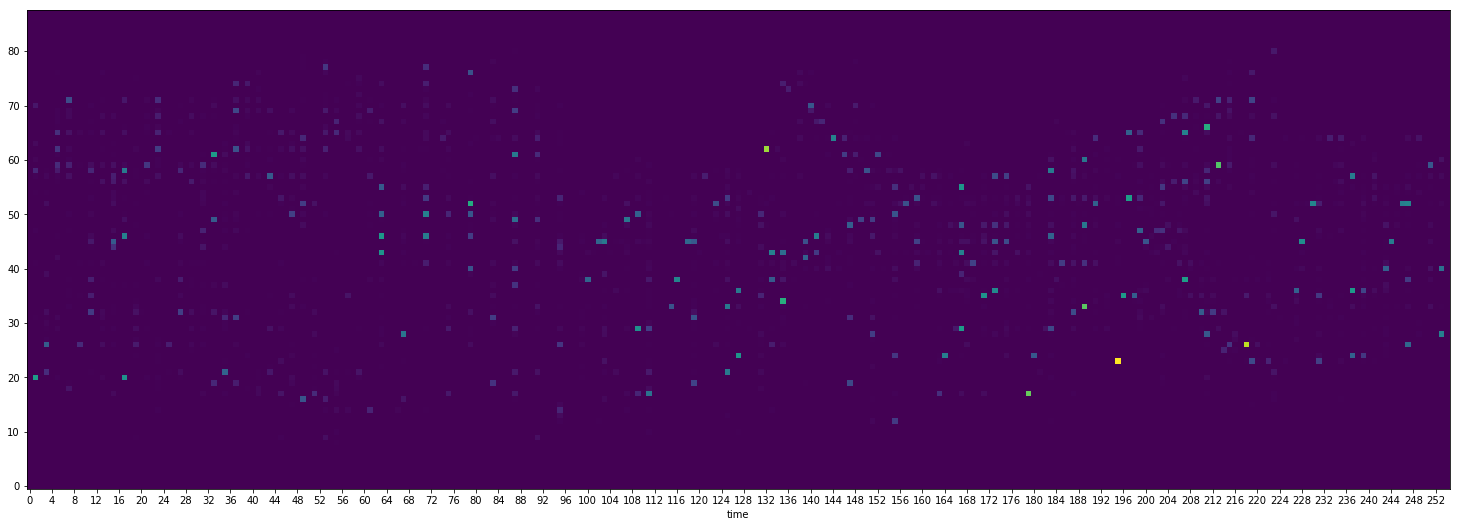

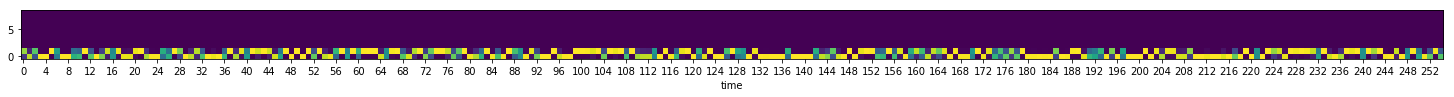

0.0272819  mean for last:  0.0250631


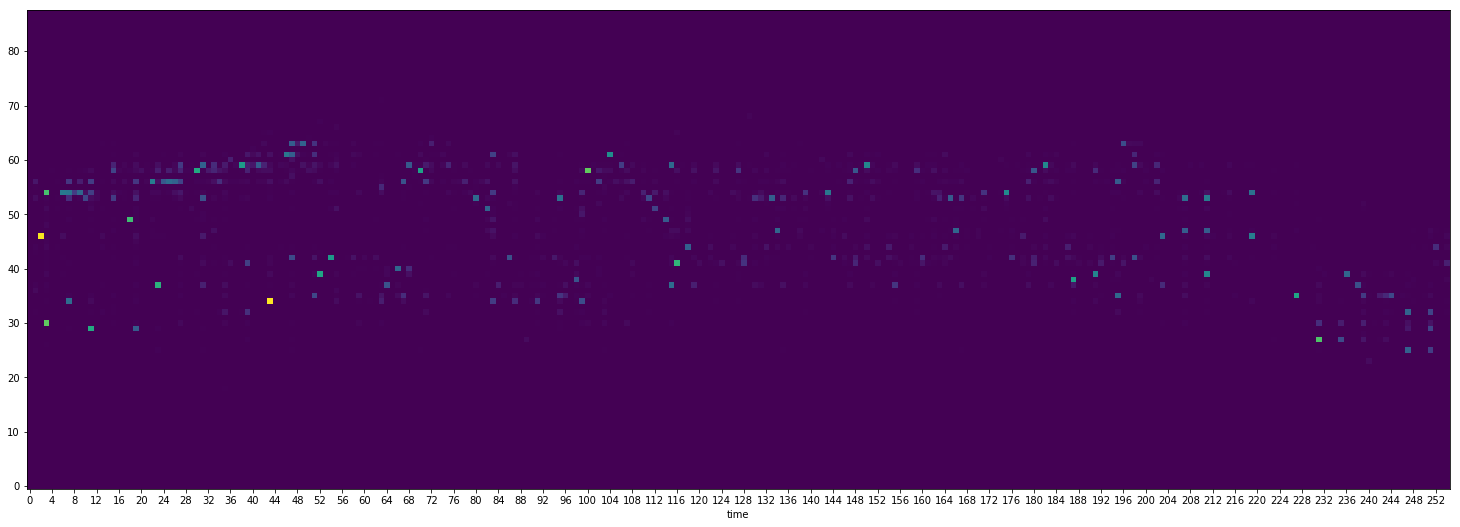

KeyboardInterrupt: 

In [20]:
training_steps = 200000
display_step = 50

losses = []
voice_losses = [[] for _ in range(len(HISTORY_TIMES) + 1)]

for step in range(training_steps + 1):
    # getting data
    batch_x = hsongs[np.random.choice(np.arange(len(hsongs)), batch_size)]
    # Run optimization step
    sess.run(train_op, feed_dict={X: batch_x})
    
    L = sess.run([ce, capsule_ce], feed_dict={X: batch_x})
    losses.append(L[0].mean())
    for i in range(len(HISTORY_TIMES) + 1):
        voice_losses[i].append(L[1][i].mean())
    
    if np.isnan(L[0]).any():
        print(" DAMN NAN ERROR")
        break
    
    if step % display_step == 0:
        print(L[0].mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0][0])
        saver.save(sess, "./tmp/100for9-predictions 100-ruler hard-union LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01 sgl.ckpt")
        
        if step % 200 == 0:
            proba = sess.run(ruler_output, feed_dict={X: batch_x})
            drawNotes(proba[0])
        
print("Optimization Finished!")

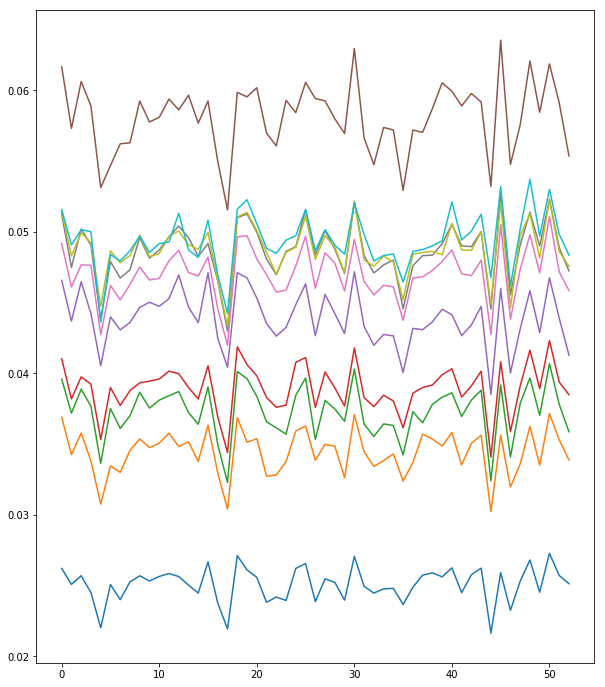

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 12

plt.plot(losses)
for i in range(len(HISTORY_TIMES) + 1):
    plt.plot(voice_losses[i])

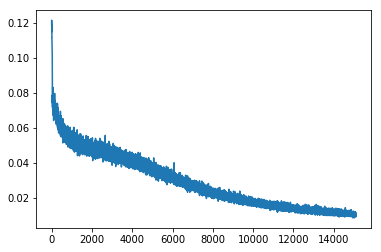

In [43]:
plt.plot(losses)  #24for9-100

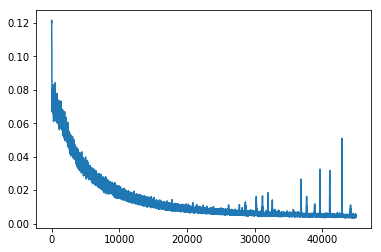

In [13]:
plt.plot(losses)  # 100-100

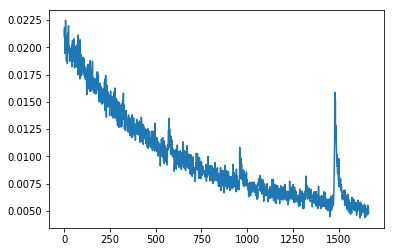

In [11]:
plt.plot(losses)  # one layer, from ~2000 epoch

(0, 0.1)

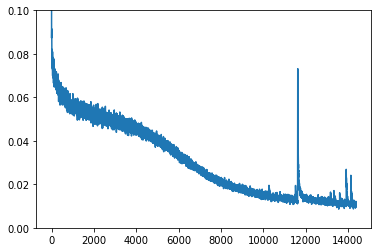

In [38]:
plt.plot(losses)
plt.ylim(0, 0.1)  # no voices mechanizm, one layer

In [76]:
gen = songs[36][:32]

In [77]:
saver.restore(sess, "./tmp/100for9-predictions 100-ruler hard-union LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/100for9-predictions 100-ruler hard-union LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt


0.0218212  mean for last:  0.0218212


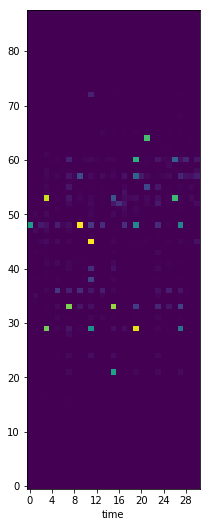

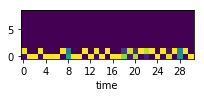

0.0173069  mean for last:  0.0173069


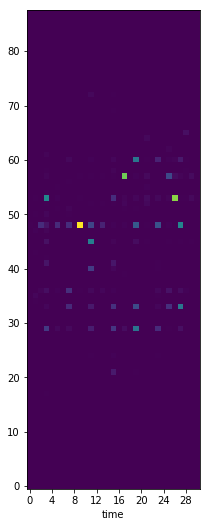

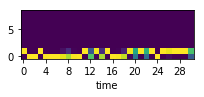

0.0136039  mean for last:  0.0136039


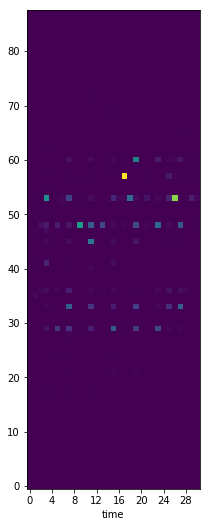

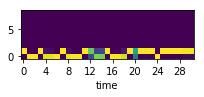

0.0116122  mean for last:  0.0116122


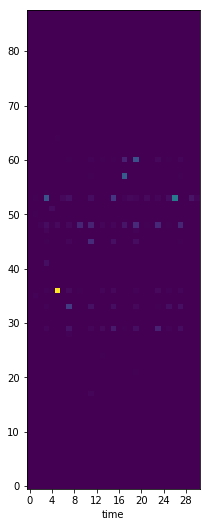

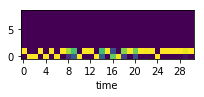

0.0101082  mean for last:  0.0101082


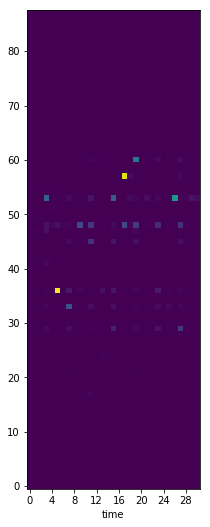

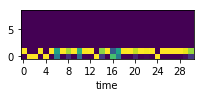

0.00610041  mean for last:  0.00610041


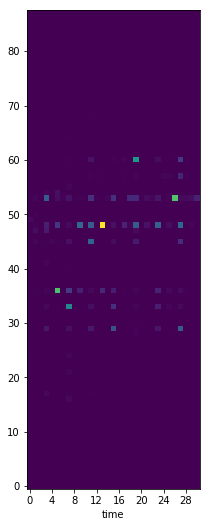

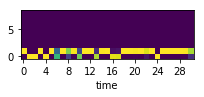

Optimization Finished!


In [68]:
training_steps = 5
display_step = 1

losses = []
voice_losses = [[] for _ in range(len(HISTORY_TIMES) + 1)]

for step in range(training_steps + 1):
    # getting data
    batch_x = np.repeat(transform(gen)[None], batch_size, axis=0)
    # Run optimization step
    sess.run(train_op, feed_dict={X: batch_x})
    
    L = sess.run([ce, capsule_ce], feed_dict={X: batch_x})
    losses.append(L[0].mean())
    for i in range(len(HISTORY_TIMES) + 1):
        voice_losses[i].append(L[1][i].mean())
    
    if np.isnan(L[0]).any():
        print(" DAMN NAN ERROR")
        break
    
    if step % display_step == 0:
        print(L[0].mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0][0])
        
        proba = sess.run(ruler_output, feed_dict={X: batch_x})
        drawNotes(proba[0])
        
print("Optimization Finished!")

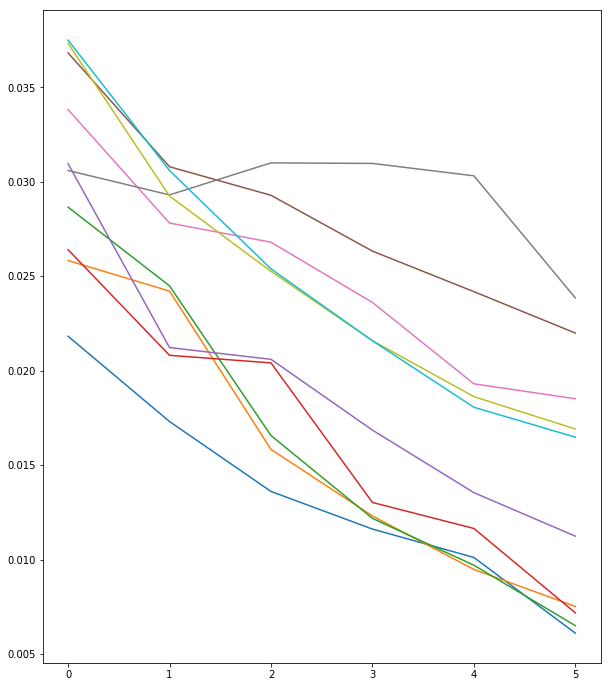

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 12

plt.plot(losses)
for i in range(len(HISTORY_TIMES) + 1):
    plt.plot(voice_losses[i])

In [ ]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()

# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, 88))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat // FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

In [70]:
gen = songs[36][:16]

In [61]:
saver.restore(sess, "./tmp/100for9-predictions 100-ruler hard-union LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/100for9-predictions 100-ruler hard-union LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt


In [71]:
while len(gen) < 256:
    gen = np.vstack([gen, np.zeros((88))])
    
    probas = sess.run(voices_proba, feed_dict={X: np.repeat(transform(gen)[None], batch_size, axis=0)})

    for i in range(voices):
        note = np.random.choice(range(89), p=probas[i][0, -1])
        if note != 88:
            gen[-1, note] = 1
    
    print('|', end="")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

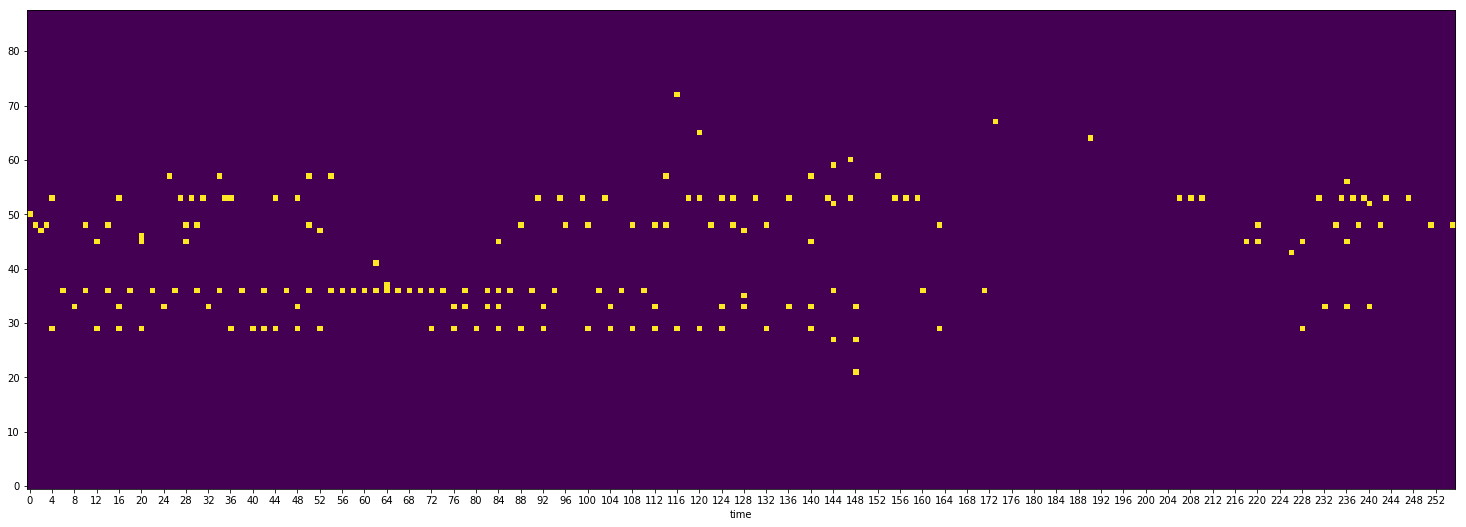

In [72]:
drawNotes(gen)

In [73]:
ms = MySong(gen, finished=True)

In [75]:
ms.play()

In [66]:
#ms.save_file("24for9-100 LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.001 15000 epochs ex.2")